In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd

# Data Importation

In [392]:
data_path = 'data/'

df_DowJones = pd.read_csv(data_path + 'DowJones.csv',header=0,delimiter=",")
df_Nasdaq = pd.read_csv(data_path + 'Nasdaq.csv',header=0,delimiter=",")
df_Russell2000 = pd.read_csv(data_path + 'Russell2000.csv',header=0,delimiter=",")
df_SP500 = pd.read_csv(data_path + 'SP500.csv',header=0,delimiter=",")

In [393]:
df_DowJones

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-12-08,19559.939453,19664.970703,19527.830078,19614.810547,324570000,19614.810547
1,2016-12-07,19241.990234,19558.419922,19229.830078,19549.619141,385200000,19549.619141
2,2016-12-06,19219.910156,19255.890625,19184.740234,19251.779297,284960000,19251.779297
3,2016-12-05,19244.349609,19274.849609,19186.730469,19216.240234,317800000,19216.240234
4,2016-12-02,19161.250000,19196.140625,19141.179688,19170.419922,84920000,19170.419922
...,...,...,...,...,...,...,...
7296,1987-12-30,1935.339966,1966.180054,1925.729980,1950.099976,15120000,1950.099976
7297,1987-12-29,1942.810059,1951.760010,1918.099976,1926.890015,9940000,1926.890015
7298,1987-12-28,1955.569946,1966.180054,1921.920044,1942.969971,13870000,1942.969971
7299,1987-12-24,2003.810059,2013.099976,1985.739990,1999.670044,8080000,1999.670044


In [90]:
df_DowJones = df_DowJones.reindex(index=df_DowJones.index[::-1])
df_Nasdaq = df_Nasdaq.reindex(index=df_Nasdaq.index[::-1])
df_Russell2000 = df_Russell2000.reindex(index=df_Russell2000.index[::-1])
df_SP500 = df_SP500.reindex(index=df_SP500.index[::-1])

DJ = np.asarray(df_DowJones['Adj Close'])
Nasdaq = np.asarray(df_Nasdaq['Adj Close'])
Rus = np.asarray(df_Russell2000['Adj Close'])
SP500 = np.asarray(df_SP500['Adj Close'])

DJ = DJ.reshape(len(DJ),1)
Nasdaq = Nasdaq.reshape(len(Nasdaq),1)
Rus = Rus.reshape(len(Rus),1)
SP500 = SP500.reshape(len(SP500),1)

In [91]:
dates = np.asarray(df_DowJones.Date)

In [92]:
ts = np.concatenate((DJ.transpose(),Nasdaq.transpose(),Rus.transpose(),SP500.transpose()))

In [93]:
ts_log = np.zeros(ts.shape)
for i in range(ts_log.shape[0]):
    for j in range(1,ts_log.shape[1]):
        ts_log[i][j] = np.log(ts[i][j]/ts[i][j-1])   

In [94]:
df_data = pd.DataFrame(ts_log.transpose(),index=dates,columns=['DowJones','Nasdaq','Russell2000','SP500'])

In [95]:
df_data

,DowJones,Nasdaq,Russell2000,SP500
1987-12-23,0.000000,0.000000,0.000000,0.000000
1987-12-24,-0.002981,0.005115,0.006518,-0.004474
1987-12-28,-0.028764,-0.023073,-0.021531,-0.025966
1987-12-29,-0.008310,-0.000307,-0.005900,-0.003999
1987-12-30,0.011973,0.012821,0.010093,0.013281
...,...,...,...,...
2016-12-02,-0.001121,0.000864,0.000342,0.000397
2016-12-05,0.002387,0.010079,0.017753,0.005804
2016-12-06,0.001848,0.004531,0.011061,0.003405
2016-12-07,0.015352,0.011329,0.008715,0.013077


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12cb07850>,
      dtype=object)

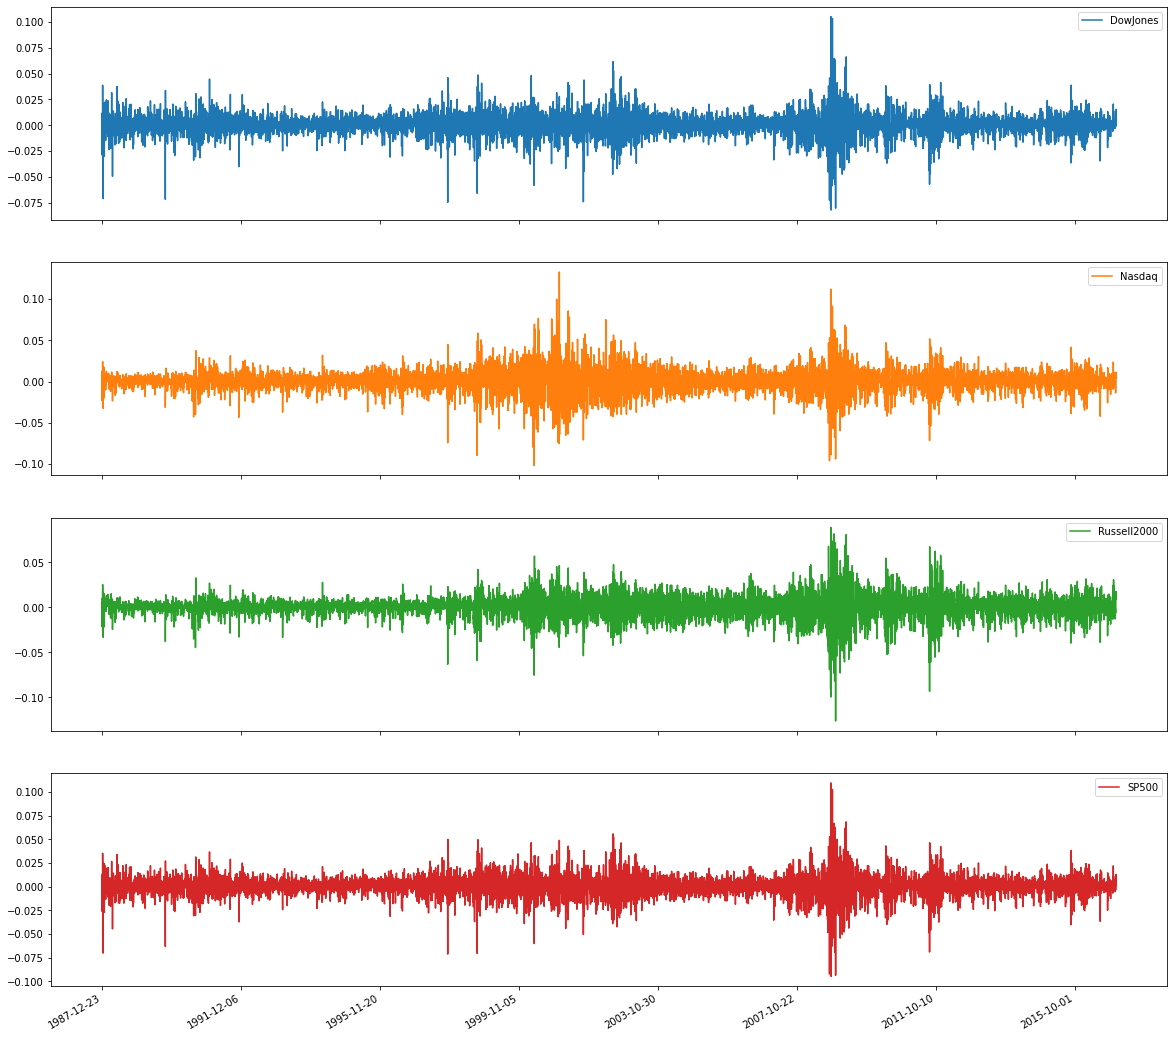

In [391]:
df_data.plot(subplots=True,figsize=(20,20))

# Persistence Landscapes

In [292]:
def persitence_landscape(dgm,k,x_min,x_max,nb_nodes,nb_ld):
    '''
    Compute persistence landscapes
    
    Parameters: 
        dgm: a persistence diagram in the Gudhi format
        k: dimension
        x_min and x_max: the endpoints of an interval
        nb_nodes: number of nodes of a regular grid on [x_min,x_max]
        nb_ld: number of landscapes
    
    Returns: 
        a nb_ld*nb_nodes array storing the values of the first nb_ld landscapes of dgm on the nodes of the grid
    '''
    x_seq = np.linspace(x_min,x_max,nb_nodes)
    #x_len = len(x_seq)
    
    flatdgm = []
    for i in dgm:
        flatdgmi = [i[0], i[1][0], i[1][1]]
        flatdgm.append(flatdgmi)
    ar_dgm = np.asarray(flatdgm)
    df_dgm = pd.DataFrame(flatdgm, columns = ['dim', 'birth', 'death'])
    df_dgm_dim = df_dgm.loc[df_dgm['dim']== k]
    ar_dgm_dim = np.asarray(df_dgm_dim)
    nb_rows = ar_dgm_dim.shape[0]
    
    if nb_rows == 0:
        return np.repeat(0, nb_nodes)
    
    f = np.zeros((nb_nodes, nb_rows))
    
    for i in range(nb_rows):
        b, d = ar_dgm_dim[i][1], ar_dgm_dim[i][2]
        def func(x):
            if (x > b and x <= (b+d)/2):
                return x-b
            elif (x > (b+d)/2 and x < d):
                return -x+d
            else:
                return 0
        for j in range(nb_nodes):
            f[j][i] = func(x_seq[j])
    for j in range(nb_nodes):
        f[j] = sorted(f[j], reverse=True)
    
    landscapes = np.nan_to_num(np.transpose(f[:,:nb_ld]))

    return landscapes
        

In [385]:
def plot_rips_and_landscape(date, w):
    '''
    Plot persistence diagram and associated landscape
    
    Parameters: 
        date: end date of the window studied
        w: size of the window
    '''
    idx = np.where(dates == date)[0][0]
    dates_window = dates[idx-w:idx]
    df_window = df_data[df_data.index.isin(dates_window)]
    ar_window = np.asarray(df_window)
    
    rips_complex = gd.RipsComplex(points=ar_window)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence(min_persistence=0)#homology_coeff_field=2, min_persistence=0)
    plt.figure(figsize=(8,5))
    axes = plt.axes()
    x_max = gd.plot_persistence_diagram(diag,axes=axes).viewLim.x1
    plt.show()
    plt.figure(figsize=(8,5))
    land = persitence_landscape(diag,1,0,x_max,1000,1)
    plt.plot(land[0])
    plt.title('Persistence landscape')
    plt.xlabel('(d+b)/2')
    plt.ylabel('(d-b)/2')
    plt.show()
    
    
    

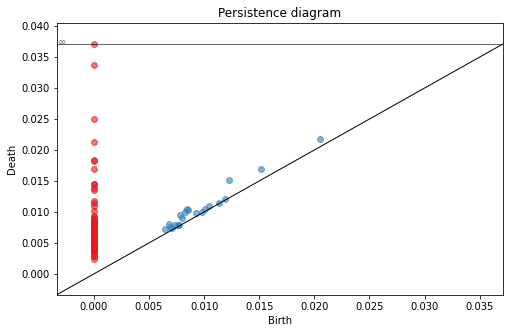

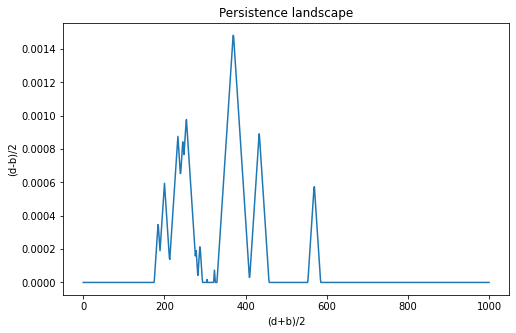

In [387]:
plot_rips_and_landscape('2000-01-10',80)

In [347]:
def get_norms(w):
    '''
    Compute the series of L1 and L2 norms of persistence landscapes
    
    Parameters: 
        w: size of the windows for the landscapes computations
    
    Returns: 
        L1: 
        L2:
    '''
    L1,L2 = np.zeros(len(dates)),np.zeros(len(dates))
    for idx in range(w,len(dates)):
        dates_window = dates[idx-w:idx]
        df_window = df_data[df_data.index.isin(dates_window)]
        ar_window = np.asarray(df_window)
    
        rips_complex = gd.RipsComplex(points=ar_window)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        diag = simplex_tree.persistence(min_persistence=0)#homology_coeff_field=2, min_persistence=0)
        land = persitence_landscape(diag,1,0,0.08,1000,1)
        
        norm1 = np.linalg.norm(land, ord=1)
        norm2 = np.linalg.norm(land)
        L1[idx] = norm1
        L2[idx] = norm2
    return L1,L2

In [379]:
def plot_norms(start_date, end_date, w):
    '''
    Plot L1 and L2 norms series
    
    Parameters: 
        start_date: start date of the period studied
        end_date: end date of the period studied
        w: size of the windows for the landscapes computation
    '''
    L1,L2 = get_norms(w)
    idx_start = np.where(dates == start_date)[0][0]
    idx_end = np.where(dates == end_date)[0][0]
    L1_r, L2_r = L1[idx_start:idx_end],L2[idx_start:idx_end]
    L1_r_normalized, L2_r_normalized = (L1_r-np.min(L1_r))/(np.max(L1_r)-np.min(L1_r)), (L2_r-np.min(L2_r))/(np.max(L2_r)-np.min(L2_r)) 
    plt.figure(figsize=(8,5))
    plt.plot(L1_r_normalized, color='r', label = 'L1')
    plt.plot(L2_r_normalized, color='b', label = 'L2')
    plt.title('Normalized L1 and L2 norms of persistence landscapes')
    plt.legend()
    plt.show()


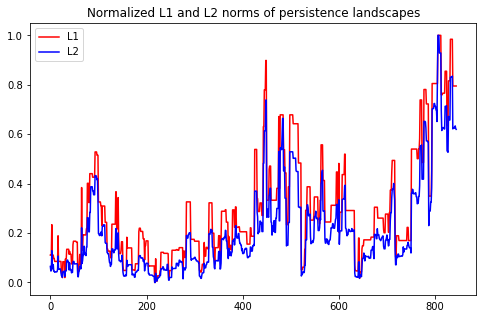

In [381]:
plot_norms('1997-01-03', '2000-05-10', 50)

In [413]:
L1,L2 = get_norms(50)

-------

## Tests stats

In [479]:
def variance(L):
    V = np.zeros(len(dates))
    for idx in range(500,len(dates)):
        L_window = L[idx-500:idx]
        var = np.var(L_window)
        V[idx] = var
    return V

In [553]:
from scipy import signal 

def av_spectral_density(L):
    SD = np.zeros(len(dates))
    for idx in range(500,len(dates)):
        L_window = L[idx-500:idx]
        f, Pxx_den = signal.periodogram(L_window)
        f, Pxx_den = np.delete(f,0), np.delete(Pxx_den,0)
        f, Pxx_den = f[0:len(f)//8], Pxx_den[0:len(f)//8]
        SD[idx] = np.mean(Pxx_den)
    return SD

In [580]:
def acf_firstlag(L):
    AC = np.zeros(len(dates))
    for idx in range(500,len(dates)):
        L_window = L[idx-500:idx]
        acf = np.correlate(L_window, L_window, mode='full')
        acf = acf[acf.size // 2:]
        AC[idx] = acf[1]
    return AC

In [575]:
def plot_stats(L1,L2,crash):
    V1, SD1, AC1 = variance(L1), av_spectral_density(L1), acf_firstlag(L1)
    V2, SD2, AC2 = variance(L2), av_spectral_density(L2), acf_firstlag(L2)
    if crash == '2000':
        date = '2000-03-10'
    if crash == '2008':
        date = '2008-09-15'
    idx_date = np.where(dates == date)[0][0]
    
    plt.figure(figsize=(18,10))
    plt.subplot(2, 3, 1)
    plt.plot(V1[idx_date-250:idx_date])
    plt.title('Variance L1')
    
    plt.subplot(2, 3, 2)
    plt.plot(SD1[idx_date-250:idx_date])
    plt.title('Spectrum L1')
    
    plt.subplot(2, 3, 3)
    plt.plot(AC1[idx_date-250:idx_date])
    plt.title('ACF(1) L1')
    
    plt.subplot(2, 3, 4)
    plt.plot(V2[idx_date-250:idx_date])
    plt.title('Variance L2')
    
    plt.subplot(2, 3, 5)
    plt.plot(SD2[idx_date-250:idx_date])
    plt.title('Spectrum L2')
    
    plt.subplot(2, 3, 6)
    plt.plot(AC2[idx_date-250:idx_date])
    plt.title('ACF(1) L2')
    
    plt.show()

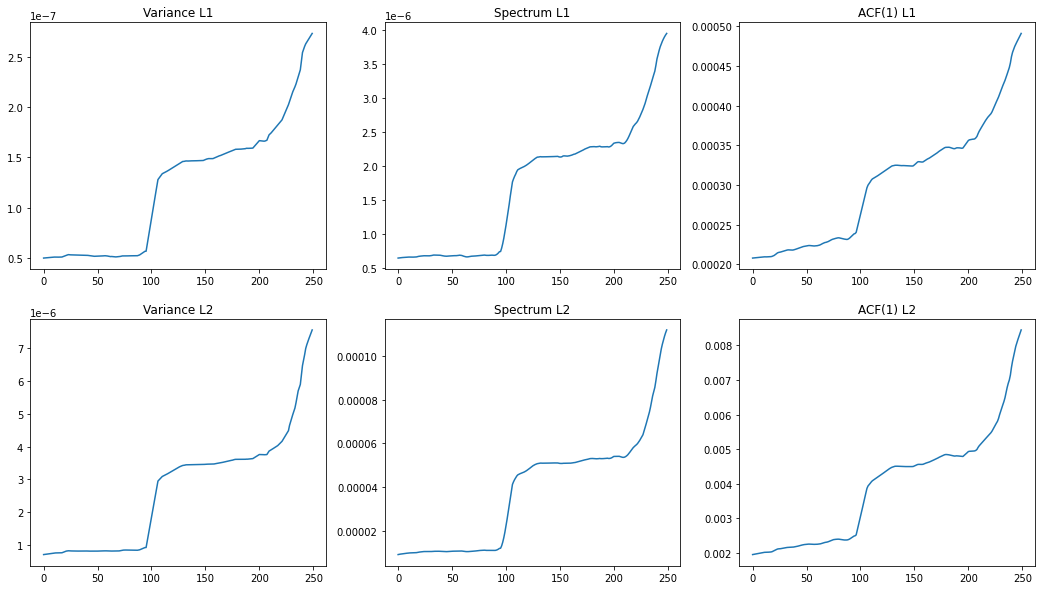

In [581]:
plot_stats(L1,L2,'2008')

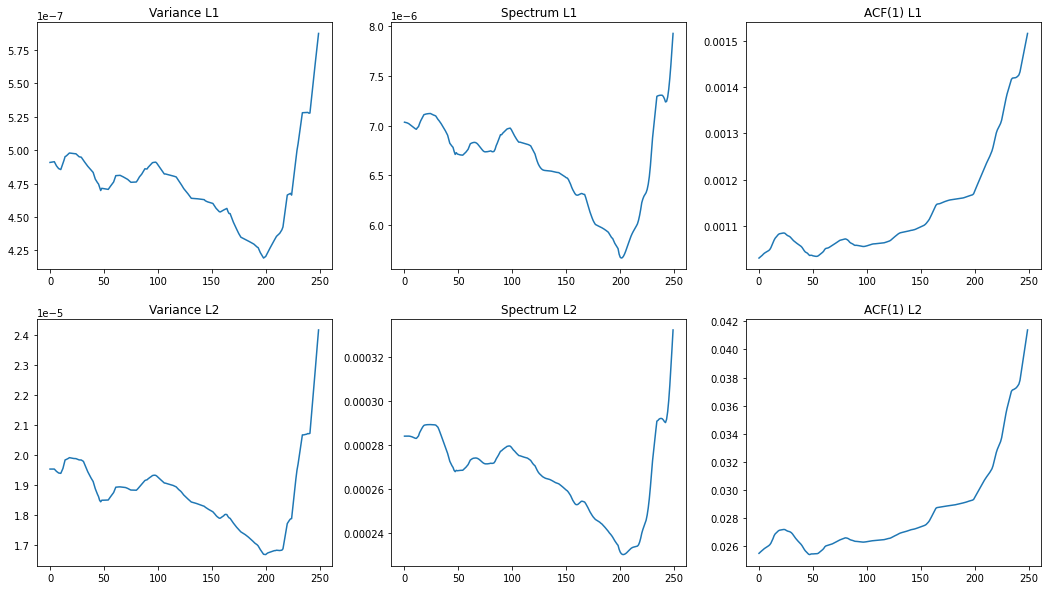

In [582]:
plot_stats(L1,L2,'2000')

In [572]:
import pymannkendall as mk

def mann_kendall_test(L1,L2,crash):
    V1, SD1, AC1 = variance(L1), av_spectral_density(L1), acf_firstlag(L1)
    V2, SD2, AC2 = variance(L2), av_spectral_density(L2), acf_firstlag(L2)
    if crash == '2000':
        date = '2000-03-10'
    if crash == '2008':
        date = '2008-09-16'
    idx_date = np.where(dates == date)[0][0]
    
    V1, SD1, AC1 = V1[idx_date-250:idx_date], SD1[idx_date-250:idx_date], AC1[idx_date-250:idx_date]
    V2, SD2, AC2 = V2[idx_date-250:idx_date], SD2[idx_date-250:idx_date], AC2[idx_date-250:idx_date]
    
    MKV1 = mk.original_test(V1)
    MKSD1 = mk.original_test(SD1)
    MKAC1 = mk.original_test(AC1)
    print("Results of the Mann Kendall Test for the L1-norm (crash: %s): " % date)
    print("Variance: trend = %s ; tau = %s" % (MKV1.trend, MKV1.Tau))
    print("Spectral Density: trend = %s ; tau = %s" % (MKSD1.trend, MKSD1.Tau))
    print("Autocorrelation: trend = %s ; tau = %s" % (MKAC1.trend, MKAC1.Tau))
    
    MKV2 = mk.original_test(V2)
    MKSD2 = mk.original_test(SD2)
    MKAC2 = mk.original_test(AC2)
    print("\nResults of the Mann Kendall Test for the L2-norm (crash: %s): " % date)
    print("Variance: trend = %s ; tau = %s" % (MKV2.trend, MKV2.Tau))
    print("Spectral Density: trend = %s ; tau = %s" % (MKSD2.trend, MKSD2.Tau))
    print("Autocorrelation: trend = %s ; tau = %s" % (MKAC2.trend, MKAC2.Tau))
    

In [573]:
mann_kendall_test(L1,L2,'2008')

Results of the Mann Kendall Test for the L1-norm (crash: 2008-09-16): 
Variance: trend = increasing ; tau = 0.8910200803212851
Spectral Density: trend = increasing ; tau = 0.916273092369478
Autocorrelation: trend = increasing ; tau = 0.9738473895582329

Results of the Mann Kendall Test for the L2-norm (crash: 2008-09-16): 
Variance: trend = increasing ; tau = 0.947566265060241
Spectral Density: trend = increasing ; tau = 0.9475020080321285
Autocorrelation: trend = increasing ; tau = 0.9728835341365462


In [574]:
mann_kendall_test(L1,L2,'2000')

Results of the Mann Kendall Test for the L1-norm (crash: 2000-03-10): 
Variance: trend = decreasing ; tau = -0.38795180722891565
Spectral Density: trend = decreasing ; tau = -0.4700722891566265
Autocorrelation: trend = increasing ; tau = 0.7831325301204819

Results of the Mann Kendall Test for the L2-norm (crash: 2000-03-10): 
Variance: trend = decreasing ; tau = -0.430425702811245
Spectral Density: trend = decreasing ; tau = -0.48086746987951806
Autocorrelation: trend = increasing ; tau = 0.7785060240963856


In [ ]:
# Suite pas necessaire

In [492]:
def plot_stats_uni(L,crash):
    V, SD, AC = variance(L), av_spectral_density(L), acf_firstlag(L)
    if crash == '2000':
        date = '2000-03-10'
    if crash == '2008':
        date = '2008-09-15'
    idx_date = np.where(dates == date)[0][0]
    plt.figure(figsize=(18,10))
    plt.subplot(1, 3, 1)
    plt.plot(V[idx_date-250:idx_date])
    plt.title('Variance')
    
    plt.subplot(1, 3, 2)
    plt.plot(SD[idx_date-250:idx_date])
    plt.title('Spectrum')
    
    plt.subplot(1, 3, 3)
    plt.plot(AC[idx_date-250:idx_date])
    plt.title('ACF(1)')
    
    plt.show()

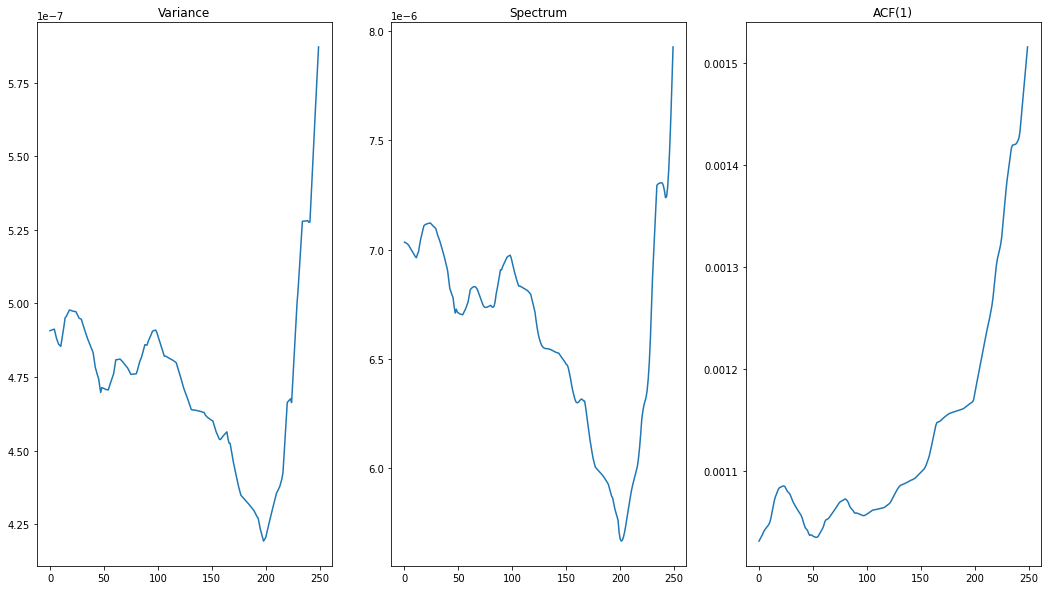

In [493]:
plot_stats_uni(L1,'2000')

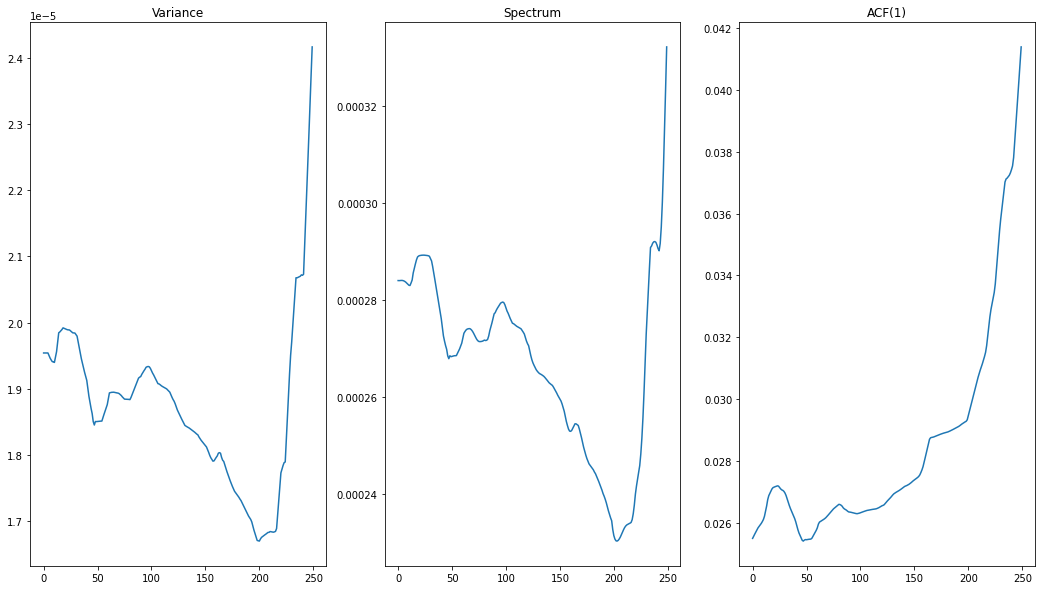

In [494]:
plot_stats_uni(L2,'2000')

------

# Bootleneck (question 4)

In [279]:
def get_bottleneck_distance(w):
    bn = np.zeros(len(dates))
    prev_diag_b = None  
    for idx in range(w,len(dates)):
        dates_window = dates[idx-w:idx]
        df_window = df_data[df_data.index.isin(dates_window)]
        ar_window = np.asarray(df_window)
    
        rips_complex = gd.RipsComplex(points=ar_window)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        current_diag = simplex_tree.persistence(min_persistence=0)#homology_coeff_field=2, min_persistence=0)
        current_diag_b = []
        for i in range(len(current_diag)):
            if current_diag[i][0] == 1:
                current_diag_b.append([current_diag[i][1][0], current_diag[i][1][1]])
        
        if prev_diag_b != None:
            dist = gd.bottleneck_distance(current_diag_b,prev_diag_b)
            bn[idx] = dist    
        prev_diag_b = current_diag_b
    return bn
    

In [287]:
def plot_bottleneck(start_date, end_date, w):
    bn = get_bottleneck_distance(w)
    idx_start = np.where(dates == start_date)[0][0]
    idx_end = np.where(dates == end_date)[0][0]
    bn_r = bn[idx_start:idx_end]
    plt.plot(bn_r)
    plt.show()

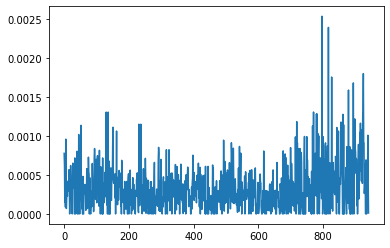

In [389]:
plot_bottleneck('2005-01-03', '2008-09-30', 80)

In [410]:
np.where(dates == '1999-01-01')

(array([], dtype=int64),)

In [411]:
dates

array(['1987-12-23', '1987-12-24', '1987-12-28', ..., '2016-12-06',
       '2016-12-07', '2016-12-08'], dtype=object)

# Tests Stats

In [525]:
bn = get_bottleneck_distance(w)

In [526]:
bn

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       1.78231833e-004, 5.15012819e-007, 1.36699058e-308])

In [557]:
def plot_stats_bn(bn,crash):
    V, SD, AC = variance(bn), av_spectral_density(bn), acf_firstlag(bn)
    if crash == '2000':
        date = '2000-03-10'
    if crash == '2008':
        date = '2008-09-15'
    idx_date = np.where(dates == date)[0][0]
    plt.figure(figsize=(18,10))
    plt.subplot(1, 3, 1)
    plt.plot(V[idx_date-250:idx_date])
    plt.title('Variance')
    
    plt.subplot(1, 3, 2)
    plt.plot(SD[idx_date-250:idx_date])
    plt.title('Spectrum')
    
    plt.subplot(1, 3, 3)
    plt.plot(AC[idx_date-250:idx_date])
    plt.title('ACF(1)')
    
    plt.show()

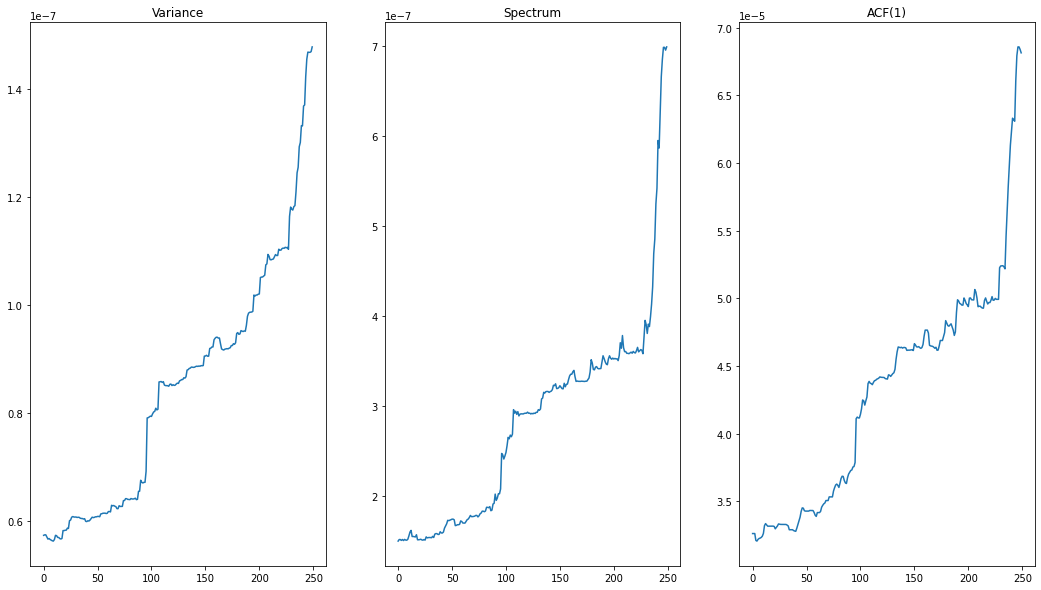

In [558]:
plot_stats_bn(bn,'2008')

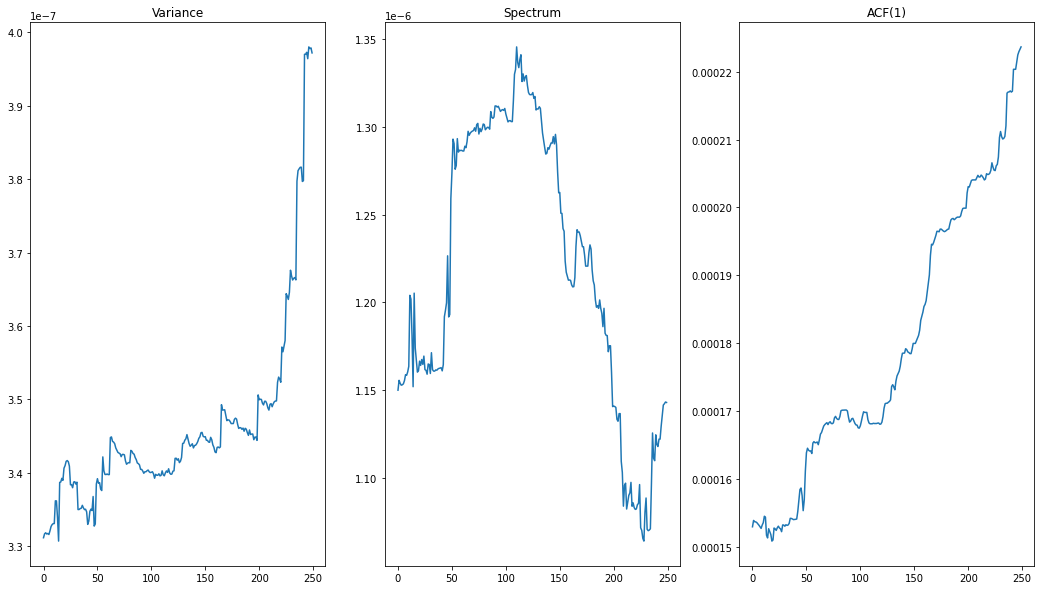

In [563]:
plot_stats_bn(bn,'2000')

In [561]:
def mann_kendall_test_bn(bn,crash):
    V, SD, AC = variance(bn), av_spectral_density(bn), acf_firstlag(bn)
    if crash == '2000':
        date = '2000-03-10'
    if crash == '2008':
        date = '2008-09-15'
    idx_date = np.where(dates == date)[0][0]
    
    V, SD, AC = V[idx_date-250:idx_date], SD[idx_date-250:idx_date], AC[idx_date-250:idx_date]
    
    MKV = mk.original_test(V)
    MKSD = mk.original_test(SD)
    MKAC = mk.original_test(AC)
    print("Results of the Mann Kendall Test for Bottleneck Distances (crash: %s): " % date)
    print("Variance: trend = %s ; tau = %s" % (MKV.trend, MKV.Tau))
    print("Spectral Density: trend = %s ; tau = %s" % (MKSD.trend, MKSD.Tau))
    print("Autocorrelation: trend = %s ; tau = %s" % (MKAC.trend, MKAC.Tau))


In [562]:
mann_kendall_test_bn(bn,'2008')

Results of the Mann Kendall Test for Bottleneck Distances (crash: 2008-09-15): 
Variance: trend = increasing ; tau = 0.9562409638554217
Spectral Density: trend = increasing ; tau = 0.9415903614457831
Autocorrelation: trend = increasing ; tau = 0.9186506024096386


In [564]:
mann_kendall_test_bn(bn,'2000')

Results of the Mann Kendall Test for Bottleneck Distances (crash: 2000-03-10): 
Variance: trend = increasing ; tau = 0.7521927710843374
Spectral Density: trend = decreasing ; tau = -0.22666666666666666
Autocorrelation: trend = increasing ; tau = 0.9144096385542169
